In [86]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

在train_iter中，每个词元都表示为一个数字索引， 将这些索引直接输入神经网络可能会使学习变得困难。 我们通常将每个词元表示为更具表现力的特征向量。 最简单的表示称为独热编码（one-hot encoding），

In [87]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

每次采样的小批量数据形状是二维张量： （批量大小，时间步数）。 one_hot函数将这样一个小批量数据转换成三维张量， 张量的最后一个维度等于词表大小（len(vocab)）。 我们经常转换输入的维度，以便获得形状为 （时间步数，批量大小，词表大小）的输出。 这将使我们能够更方便地通过最外层的维度， 一步一步地更新小批量数据的隐状态。

In [88]:
X=torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

### 初始化模型参数


In [89]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### 循环神经网络模型
为了定义循环神经网络模型， 我们首先需要一个init_rnn_state函数在初始化时返回隐状态。 这个函数的返回是一个张量，张量全用0填充， 形状为（批量大小，隐藏单元数）。 在后面的章节中我们将会遇到隐状态包含多个变量的情况， 而使用元组可以更容易地处理些。

In [90]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

下面的rnn函数定义了如何在一个时间步内计算隐状态和输出。 循环神经网络模型通过inputs最外层的维度实现循环， 以便逐时间步更新小批量数据的隐状态H。 此外，这里使用tanh函数作为激活函数。 如 4.1节所述， 当元素在实数上满足均匀分布时，函数的平均值为0。

In [91]:
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        H = torch.relu(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

定义了所有需要的函数之后，接下来我们创建一个类来包装这些函数， 并存储从零开始实现的循环神经网络模型的参数

In [92]:
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

检查输出是否具有正确的形状。 例如，隐状态的维数是否保持不变。

In [93]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

### 预测
先定义预测函数来生成prefix之后的新字符， 其中的prefix是一个用户提供的包含多个字符的字符串。 在循环遍历prefix中的开始字符时， 我们不断地将隐状态传递到下一个时间步，但是不生成任何输出。 这被称为预热（warm-up）期， 因为在此期间模型会自我更新（例如，更新隐状态）， 但不会进行预测。 预热期结束后，隐状态的值通常比刚开始的初始值更适合预测， 从而预测字符并输出它们。

In [94]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [95]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller nfgggggggg'

### 梯度剪裁

In [96]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

### 训练
在训练模型之前，让我们定义一个函数在一个迭代周期内训练模型。 它与我们训练 3.6节模型的方式有三个不同之处：

序列数据的不同采样方法（随机采样和顺序分区）将导致隐状态初始化的差异。

我们在更新模型参数之前裁剪梯度。 这样的操作的目的是：即使训练过程中某个点上发生了梯度爆炸，也能保证模型不会发散。

我们用困惑度来评价模型。如 8.4.4节所述， 这样的度量确保了不同长度的序列具有可比性。

具体来说，当使用顺序分区时， 我们只在每个迭代周期的开始位置初始化隐状态。 由于下一个小批量数据中的第个子序列样本 与当前第个子序列样本相邻， 因此当前小批量数据最后一个样本的隐状态， 将用于初始化下一个小批量数据第一个样本的隐状态。 这样，存储在隐状态中的序列的历史信息 可以在一个迭代周期内流经相邻的子序列。 然而，在任何一点隐状态的计算， 都依赖于同一迭代周期中前面所有的小批量数据， 这使得梯度计算变得复杂。 为了降低计算量，在处理任何一个小批量数据之前， 我们先分离梯度，使得隐状态的梯度计算总是限制在一个小批量数据的时间步内。

当使用随机抽样时，因为每个样本都是在一个随机位置抽样的， 因此需要为每个迭代周期重新初始化隐状态。 与 3.6节中的 train_epoch_ch3函数相同， updater是更新模型参数的常用函数。 它既可以是从头开始实现的d2l.sgd函数， 也可以是深度学习框架中内置的优化函数。


In [97]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

循环神经网络模型的训练函数既支持从零开始实现， 也可以使用高级API来实现。

In [98]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

现在，我们训练循环神经网络模型。 因为我们在数据集中只使用了10000个词元， 所以模型需要更多的迭代周期来更好地收敛。

困惑度 1.0, 115974.9 词元/秒 cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


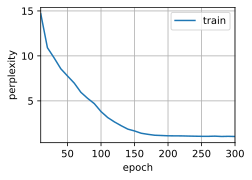

In [99]:
num_epochs, lr = 300, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

让我们检查一下使用随机抽样方法的结果。

困惑度 1.3, 116974.4 词元/秒 cuda:0
time travellerit s against reason said filbycho over the psychol
travellerit s against reason said filbycho over the psychol


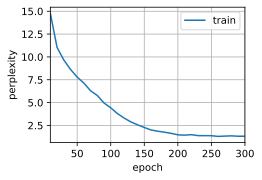

In [100]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)